# Beam patterns with ska-ost-low-uv

In [1]:
import numpy as np
import pylab as plt
from astropy.time import Time
from astropy.units import Quantity

from ska_ost_low_uv.postx import ApertureArray

## ApertureArray class

The `ApertureArray` class was designed to help with QA on MCCS station data. It has:
* plotting utilities (e.g. view antennas, view correlation matrix)
* A basic imager (direct post-correlation beamforming approach)
* An all-sky image viewer (orthographic and mollweide views, source overlays, satellite overlays)
* coordinate utilities (get zenith, sun position)
* Sattelite utilities (compute apparent RA/DEC)
* simple simulation utilities (pygdsm maps, visibilities, station beam pattern),
* some calibration algorithms (self-holography, stefcal)

I have recently updated it so you can create an `ApertureArray` without loading any UV data. This makes it useful for computing source locations, and the latest version can compute station beam patterns.

In [2]:
aa = ApertureArray(station_id='s8-6')

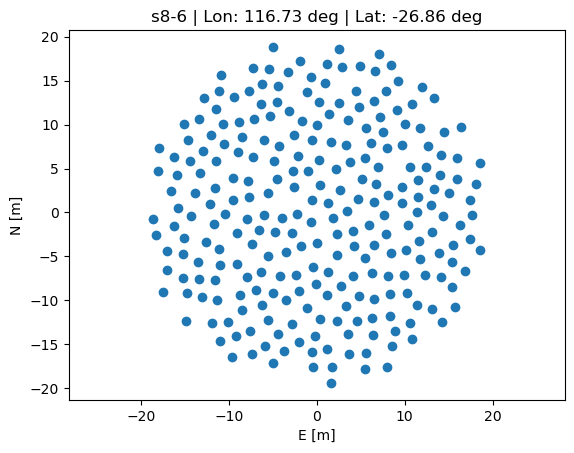

In [3]:
aa.plotting.plot_antennas()

## Simulate a station beam

We can simulate a station beam without loading data, if we set a frequency and time.

In [4]:
# Set observation frequency and time
f = Quantity([100], unit='MHz')
t = Time(['2000-01-01 08:00:00'], format='iso')

# Create ApertureArray object
aa = ApertureArray(station_id='s8-6', sim_f=f, sim_t=t)

pc = aa.coords.get_zenith()  # set pointing centre/phase centre to zenith
sun = aa.coords.get_sun()  # an alternative pointing centre

We will use the `aa.simulation.sim_station_beam()` method:

In [5]:
aa.simulation.help()

<Aperture Array module: simulation>

Simulate visibilities, pygdsm diffuse sky model, and station beam simulation.

Provides the following methods:
    help() - Print help for this class module.
    mollview_gsm() - View diffuse sky model (Mollweide).
    orthview_gsm() - View diffuse sky model (Orthographic).
    orthview_station_beam() - Plot beam pattern: 2D orthographic view.
    plot_station_beam_cuts() - Plot beam pattern cuts through pointing centre.
    sim_station_beam() - Simulate beam pattern.
    sim_vis_gsm() - Generate visibilities, based on the Global Sky Model.
    sim_vis_pointsrc() - Simulate model visibilities for an antenna array.


(257, 257)


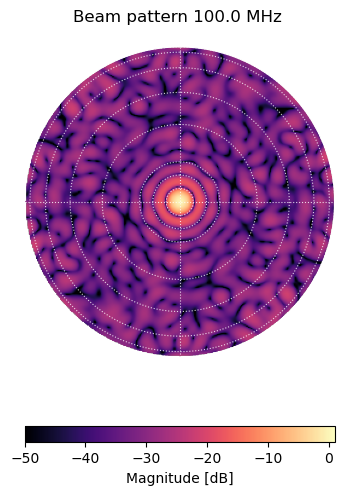

In [6]:
beam_pattern = aa.simulation.sim_station_beam(phase_center=pc, show=False, n_pix=257, db=False)
print(beam_pattern.shape)

# We can display using imshow(), or the in-built orthview_station_beam()
# The latter overlays an azimuth-elevation grid
# plt.imshow(beam_pattern)
# plt.colorbar(label='Magnitude [dB]')
aa.simulation.orthview_station_beam(beam_pattern, db=True)

## Orthographic plot

The simulator can plot either 'orthview' or 'cut'. The 'orthview' option gives a 2D view with alt/az axes overlaid. You can also use the `aa.simulation.orthview_station_beam()` and `aa.simulation.plot_station_beam_cuts()` methods after generating a beam with `sim_station_beam`.

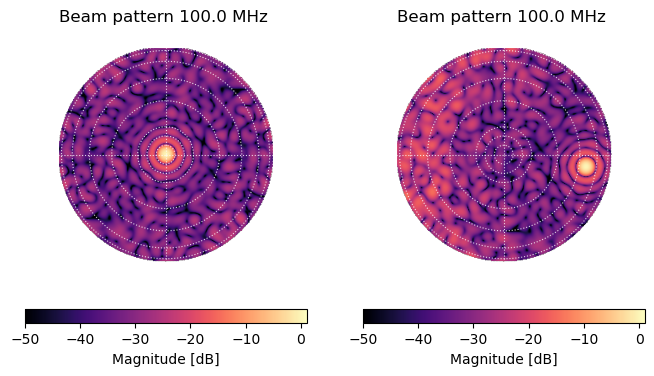

In [7]:
plt.figure(figsize=(8, 4))
_ = aa.simulation.sim_station_beam(
    phase_center=pc, show=True, plot_type='orthview', n_pix=257, subplot_id=(1, 2, 1), reuse_fig=True, db=True
)
_ = aa.simulation.sim_station_beam(
    phase_center=sun, show=True, plot_type='orthview', n_pix=257, subplot_id=(1, 2, 2), reuse_fig=True, db=True
)

## Beam cuts

The 'cut' view gives 2D cuts through the X and Y axes of the plot through the phase center.

Text(0.5, 1.0, 'Sun pointing')

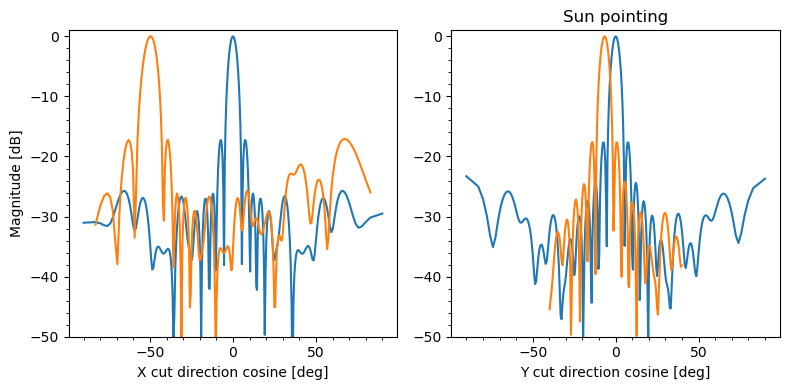

In [8]:
plt.figure(figsize=(8, 4))
beam_pattern = aa.simulation.sim_station_beam(
    phase_center=pc, show=True, plot_type='cut', n_pix=257, reuse_fig=True, subplot_id=(1, 2, 1), db=True
)
plt.title('Zenith pointing')

beam_pattern = aa.simulation.sim_station_beam(
    phase_center=sun, show=True, plot_type='cut', n_pix=257, reuse_fig=True, subplot_id=(1, 2, 1), db=True
)
plt.title('Sun pointing')

## Substations / beam weighting

The station beam simulator has a `weights` argument, which we can use to create substations, add errors, flag antennas, etc. To simulate a substation, we set the weights to zero for antennas outside the substation.

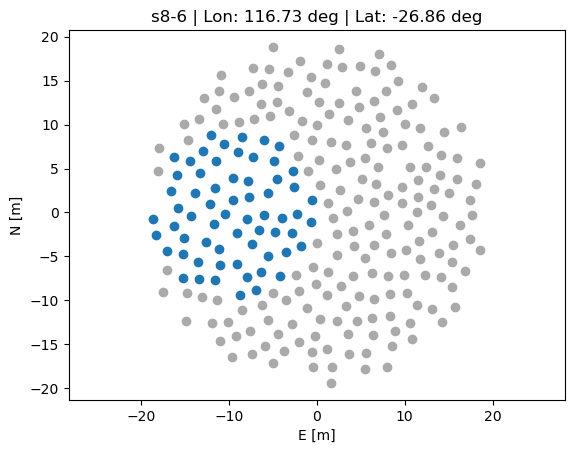

In [9]:
def select_antennas_by_radius(aa: ApertureArray, sub_origin: np.ndarray, radius: float) -> np.ndarray:
    """Select antennas within a station by radius."""
    dist = np.sqrt(np.sum((sub_origin - aa.xyz_enu) ** 2, axis=1))
    ant_sel = dist <= radius
    return ant_sel


ant_sel = select_antennas_by_radius(aa, (-38 / 4, 0, 0), 38 / 4)

aa.plotting.plot_antennas(ant_sel=ant_sel)
aa.plotting.plot_antennas(ant_sel=~ant_sel, color='#aaaaaa')

Now, we can plot the station beam by converting the antenna selection above to weights (convert bool to float):

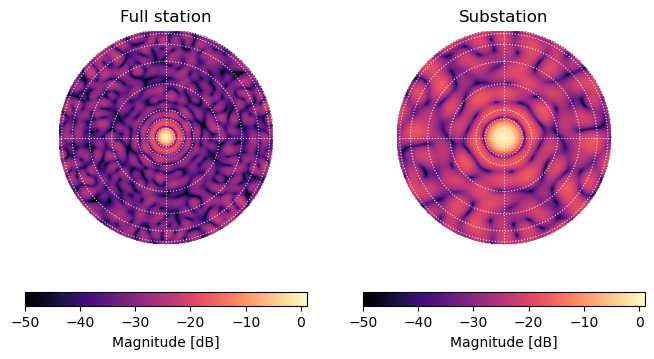

In [10]:
station_beam = aa.simulation.sim_station_beam(phase_center=pc, show=False, n_pix=257)

weights = ant_sel.astype('float32')
substation_beam = aa.simulation.sim_station_beam(phase_center=pc, show=False, n_pix=257, weights=weights)


plt.figure(figsize=(8, 4))
_ = aa.simulation.orthview_station_beam(
    station_beam, db=True, reuse_fig=True, subplot_id=(1, 2, 1), title='Full station'
)
_ = aa.simulation.orthview_station_beam(
    substation_beam, db=True, reuse_fig=True, subplot_id=(1, 2, 2), title='Substation'
)

## Include AEPs


(257, 257, 4)


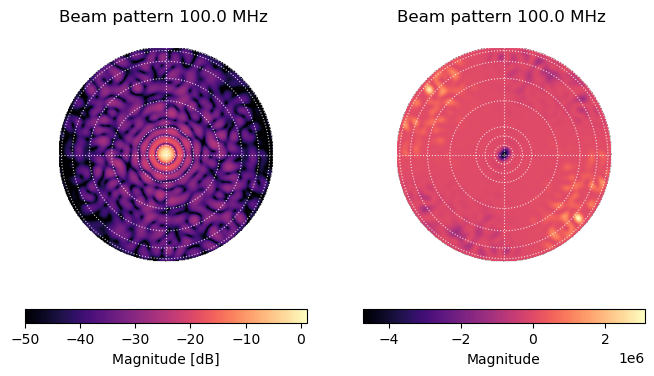

In [11]:
beam_pattern = aa.simulation.sim_station_beam(phase_center=pc, show=False, n_pix=257, db=False, apply_aep=True)
print(beam_pattern.shape)

plt.figure(figsize=(8, 4))
aa.simulation.orthview_station_beam(beam_pattern, db=True, pol_idx=0, subplot_id=(1, 2, 1), reuse_fig=True)
aa.simulation.orthview_station_beam(beam_pattern, db=False, pol_idx=1, subplot_id=(1, 2, 2), reuse_fig=True)